# 2D Algorithm Simulation

Includes:

- A 2D room simulation to model recording signals in a real environment
- A variety of implementations of (2D) beamforming algorithms based on the recorded data

In [13]:
import math
import numpy as np
import matplotlib.pyplot as plt
import pyroomacoustics as pra
from pyroomacoustics.directivities import (
    DirectivityPattern,
    DirectionVector,
    CardioidFamily,
)
from scipy.io import wavfile
from playsound import playsound

### Build Theatre Environment

Create shoebox room of similar size and characteristics to theatre to simulate in.

In [14]:
# build theatre env here

fs = 8000 # audio sampling frequency - global (set to freq of input file)

room_x = 10 # stage width
room_y = 10 # room length
order = 0 # reflection order
sigma2_n = 5e-7 # microphone noise variance estimate

m = pra.make_materials(
    ceiling="hard_surface",
    floor="stage_floor",
    east="brickwork",
    west="brickwork",
    north="brickwork",
    south="brickwork",
) # materials of each surface of room, defines signal absorption

room = pra.ShoeBox([room_x, room_y], fs=fs, materials=m, max_order=order, air_absorption=True, ray_tracing=False)

### Place microphones

Defines array geometry and places the microphones near the stage (the front of the room).

In [15]:
# design parameters of array
array_loc = [5, 0.1] # x/y location of array center
n_mics = 5 # number of microphones
sep = 0.3 # microphone separation

N = 1024 # fft length - defines N/2 + 1 frequency bands

R = pra.linear_2D_array(center=array_loc, M=n_mics, phi=0, d=sep)
mic_array = pra.Beamformer(R, room.fs, N) # uses omnidirectional mics by default
room.add_microphone_array(mic_array)

### Place sound sources

Sources can be placed anywhere, with two samples placed apart from each other on stage. The 'input_samples' folder contains all input samples, some taken from the pyroomacoustics github.

In [16]:
# Add sources on stage
source_locs = [[4, 2.1], [6, 2.1]] # locations of each source in 3D space (can modify)
source_inputs = ['input_samples/singing_8000.wav', 'input_samples/german_speech_8000.wav'] # filepaths to wav files being played by the source

for i in range(len(source_locs)):
    _, audio = wavfile.read(source_inputs[i])
    room.add_source(source_locs[i], signal=audio, delay=0)

### Beamforming Algorithms

 Delay and sum beamformer:

In [31]:
mic_array.rake_delay_and_sum_weights(
    source=room.sources[0][0:1],
    interferer=room.sources[1][0:1], # this algorithm has no way of accounting for an interferer, but shown for comparison
)
mic_array.filters_from_weights()

out_filepath = 'output_samples/DNS'

MVDR beamformer:

In [66]:
S = mic_array.rake_mvdr_filters(
    source=room.sources[0][0:1],
    interferer=room.sources[1][0:1],
    R_n=sigma2_n * np.eye(mic_array.Lg * mic_array.M) # estimated noise covariance matrix
)
out_filepath = 'output_samples/MVDR'
print(S)

KeyboardInterrupt: 

Max SINR beamformer:

In [17]:
mic_array.rake_max_sinr_weights(
    source=room.sources[0][0:1],
    interferer=room.sources[1][0:1],
    R_n=sigma2_n * np.eye(mic_array.M) # estimated noise covariance matrix
)
mic_array.filters_from_weights()
out_filepath = 'output_samples/MaxSINR'

One Forcing beamformer:

In [27]:
mic_array.rake_one_forcing_weights(
    source=room.sources[0][0:1],
    interferer=room.sources[1][0:1],
    R_n=sigma2_n * np.eye(mic_array.M) # estimated noise covariance matrix
)
mic_array.filters_from_weights()
out_filepath = 'output_samples/OneForcing'

## Simulation

Performs processing with selected beamforming algorithm above

In [18]:
room.compute_rir()
room.simulate()

# # save sound from middle mic as an estimated raw input
# raw_mic = pra.normalize(mic_array.signals[mic_array.M // 2])
# wavfile.write('combined_8000_mic_' + str(mic_array.M // 2) + '.wav', fs, raw_mic)

# # save processed sound as output
# output = mic_array.process()
# out_norm = pra.normalize(output)
# wavfile.write('combined_8000_processed.wav', fs, out_norm)

## Evaluation

min freqs:
686.0
428.75
228.66666666666666

max freqs: 
1715.0
857.5
571.6666666666666


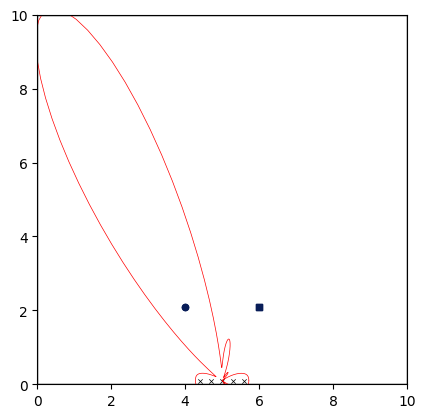

In [52]:
# plot peam pattern
fig, ax = room.plot(freq=[571.66667], img_order=0)
s = 0.10
print('min freqs:')
print(343/(5*s))
print(343/(4*2*s))
print(343/(5*3*s))

print('\nmax freqs: ')
print(343/(2*s))
print(343/(2*2*s))
print(343/(2*3*s))

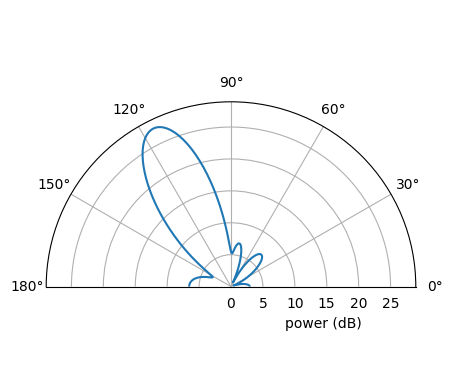

In [51]:
phis = np.arange(0,181)*np.pi/180
response = mic_array.response(phis, 500)
mag_response = abs(response[1])
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.plot(phis, mag_response)
ax.set_xlim([0, np.pi])
ax.set_xlabel('power (dB)')
ax.xaxis.set_label_coords(0.75, 0.17)

In [102]:
# store 1st beam pattern
data1 = ax.lines[0].get_data()
x1 = data1[0] - array_loc[0]
y1 = data1[1] - array_loc[1]
r1 = np.sqrt(x1**2 + y1**2)
phi1 = np.arctan2(y1, x1)

In [110]:
# store 2nd beam pattern
data2 = ax.lines[0].get_data()
x2 = data2[0] - array_loc[0]
y2 = data2[1] - array_loc[1]
r2 = np.sqrt(x2**2 + y2**2)
phi2 = np.arctan2(y2, x2)

In [118]:
# store 3rd beam pattern
data3 = ax.lines[0].get_data()
x3 = data3[0] - array_loc[0]
y3 = data3[1] - array_loc[1]
r3 = np.sqrt(x3**2 + y3**2)
phi3 = np.arctan2(y3, x3)

In [126]:
# store 4th beam pattern
data4 = ax.lines[0].get_data()
x4 = data4[0] - array_loc[0]
y4 = data4[1] - array_loc[1]
r4 = np.sqrt(x4**2 + y4**2)
phi4 = np.arctan2(y4, x4)

[Text(0, 2.0, ''),
 Text(0, 4.0, ''),
 Text(0, 6.0, ''),
 Text(0, 8.0, ''),
 Text(0, 10.0, ''),
 Text(0, 12.0, ''),
 Text(0, 14.0, ''),
 Text(0, 16.0, ''),
 Text(0, 18.0, '')]

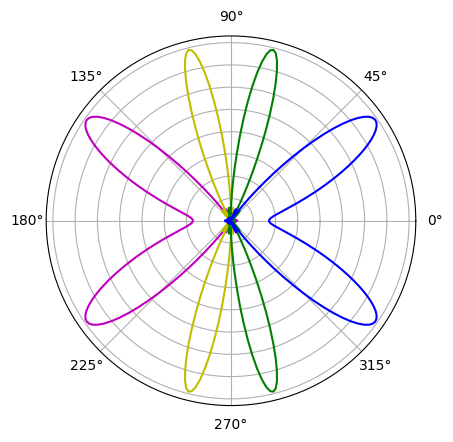

In [127]:
# polar beam pattern
fig2, ax2 = plt.subplots(subplot_kw={'projection': 'polar'})
ax2.plot(phi1, r1, 'm')
ax2.plot(phi2, r2, 'y')
ax2.plot(phi3, r3, 'g')
ax2.plot(phi4, r4, 'b')
ax2.axes.set_yticklabels([])

## Play Audio

In [17]:
playsound(out_filepath + '/combined_8000_mic_8.wav')

In [18]:
playsound(out_filepath + '/combined_8000_processed.wav')